# Secure Kaplan-Meier Survival Analysis Explained

The MPyC demo [kmsurival.py](kmsurvival.py) implements privacy-preserving Kaplan-Meier [survival analysis](https://en.wikipedia.org/wiki/Survival_analysis), based on earlier work by Meilof Veeningen. The demo is built using the Python package [lifelines](https://pypi.org/project/lifelines/), which provides extensive support for survival
analysis and includes several datasets. We use lifelines for plotting Kaplan-Meier survival curves, performing logrank tests to compare survival curves, and printing survival tables.

In [1]:
# use pip (or, conda) to make sure lifelines package is installed:
!pip -q install lifelines  

In [2]:
import os, functools
import pandas as pd
import matplotlib.pyplot as plt
import lifelines.statistics
from mpyc.runtime import mpc
mpc.logging(False)
from kmsurvival import fit_plot, events_to_table, events_from_table, logrank_test, aggregate, agg_logrank_test

Actual use of the lifelines package is hidden mostly inside the [kmsurival.py](kmsurvival.py) demo, except for the function `lifelines.statistics.logrank_test()` used below to validate the results of the secure computations.

## Kaplan-Meier Analysis

We analyze the aml ("acute myelogenous leukemia") dataset, which is also used as a [small example on Wikipedia](https://en.wikipedia.org/wiki/Survival_analysis#Example:_Acute_myelogenous_leukemia_survival_data). The file `aml.csv` (copied from the R package `KMsurv`) contains the raw data for 23 patients. Status 1 stands for the event "recurrence of aml cancer" and status 0 means no event ("censored").

In [3]:
df = pd.read_csv(os.path.join('data', 'surv', 'aml.csv')).rename(columns={'Unnamed: 0': 'observation', 'cens': 'status'})
df.sort_values(['time', 'observation']).style.hide_index()

observation,time,status,group
12,5,1,2
13,5,1,2
14,8,1,2
15,8,1,2
1,9,1,1
16,12,1,2
2,13,1,1
3,13,0,1
17,16,0,2
4,18,1,1


Time is in weeks. The study compares the time until recurrence among two groups of patients. Patients in group 1 received maintenance chemotherapy, while patients in group 2 did not get any maintenance treatment. To plot the [Kaplan–Meier survival curve](https://en.wikipedia.org/wiki/Kaplan–Meier_estimator) for groups 1 and 2, we use the function `fit_plot()` as follows.

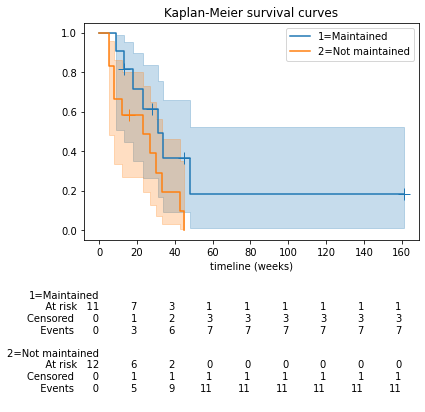

In [4]:
T1, T2 = df['time']  [df['group'] == 1], df['time']  [df['group'] == 2]
E1, E2 = df['status'][df['group'] == 1], df['status'][df['group'] == 2]
kmf1, kmf2 = fit_plot(T1, T2, E1, E2, 'Kaplan-Meier survival curves', 'weeks', '1=Maintained', '2=Not maintained')
plt.show()

The vertical ticks on the graphs indicate censored events. At the bottom, the number of patients "at risk" is shown. The study concerned 11 patients in group 1 with one patient censored after 161 weeks and 12 patients in group 2. A Kaplan-Meier curve estimates the survival probability as a function of time (duration). 

In this example, the two curves do not appear to differ very much. To analyze this more precisely one performs a [logrank test](https://en.wikipedia.org/wiki/Logrank_test):

In [5]:
lifelines.statistics.logrank_test(T1, T2, E1, E2).p_value

0.06533932204050484

The null hypothesis is that survival is the same for both groups. Since $p=0.065$ is not particularly small (e.g., not below $\alpha=0.05$), the null hypothesis is not strongly rejected. In other words, the logrank test also says that the curves do not differ significantly---with the usual caveat of small sample sizes.

## Privacy-Preserving Survival Analysis

In a multiparty setting, each party holds a private dataset and the goal is to perform a survival analysis on the *union* of all the datasets. To obtain the secure union of the datasets in an efficient way, each private dataset will be represented using two survival tables, one survival table per group of patients. 

The survival tables for the aml dataset are available from the Kaplan-Meier fitters `kmf1` and `kmf2` output by the call to `fit_plot()` above:

In [6]:
display(kmf1.event_table, kmf2.event_table)

,removed,observed,censored,entrance,at_risk
event_at,,,,,
0.0,0,0,0,11,11
9.0,1,1,0,0,11
13.0,2,1,1,0,10
18.0,1,1,0,0,8
23.0,1,1,0,0,7
28.0,1,0,1,0,6
31.0,1,1,0,0,5
34.0,1,1,0,0,4
45.0,1,0,1,0,3


,removed,observed,censored,entrance,at_risk
event_at,,,,,
0.0,0,0,0,12,12
5.0,2,2,0,0,12
8.0,2,2,0,0,10
12.0,1,1,0,0,8
16.0,1,0,1,0,7
23.0,1,1,0,0,6
27.0,1,1,0,0,5
30.0,1,1,0,0,4
33.0,1,1,0,0,3


Using `mpc.input()`, each party will secret-share its pair of survival tables with all the other parties. To allow for a simple union of the survival tables, however, we modify the representation of the survival tables as follows. 

First, we determine when the last event happens, which is at $t=161$ in the example. We compute $maxT$ securely as the maximum over all parties, using the following MPyC one-liner:

In [7]:
secfxp = mpc.SecFxp(64)  # logrank tests will require fixed-point arithmetic
maxT = int(await mpc.output(mpc.max(mpc.input(secfxp(int(df['time'].max()))))))
timeline = range(1, maxT+1)
max(timeline)

161

All parties use $1..maxT$ as the global timeline. Subsequently, each party pads its own survival tables to cover the entire timeline. This is accomplished by two calls to the function `events_to_table()`, which only keeps the essential information:

In [8]:
d1, n1 = events_to_table(maxT, T1, E1)
d2, n2 = events_to_table(maxT, T2, E2)
pd.DataFrame({'d1': d1, 'n1': n1, 'd2': d2, 'n2': n2}, index=timeline).head(10)

,d1,n1,d2,n2
1,0,11,0,12
2,0,11,0,12
3,0,11,0,12
4,0,11,0,12
5,0,11,2,12
6,0,11,0,10
7,0,11,0,10
8,0,11,2,10
9,1,11,0,8
10,0,10,0,8


Column `d1` records the number of observed events ("deaths") for group 1 on the entire timeline, and column `n1` records the number of patients "at risk". Similarly, for group 2. 

To obtain the secure union of the privately held datasets, we let all parties secret-share their survival tables and simply add all of these elementwise:

In [9]:
d1, n1, d2, n2 = (functools.reduce(mpc.vector_add, mpc.input(list(map(secfxp, _)))) for _ in (d1, n1, d2, n2))

The joint dataset (union) is now represented by `d1, n1, d2, n2`. Note that these values are all secret-shared, for example:

In [10]:
d1[0]

<mpyc.sectypes.SecFxp64:32 at 0x26f1269f820>

### Aggregate Kaplan-Meier Curves

We now proceed to analyze the joint dataset in a privacy-preserving way by plotting *aggregated* versions of the Kaplan-Meier curves. The exact Kaplan-Meier curves would reveal too much information about the patients in the study. By aggregating the events over longer time intervals, the amount of information revealed by the curves is reduced. At the same time, however, the aggregated curves may still be helpful to see the overall results for the study---and in any case to serve as a sanity check.

The function `aggregate()` securely adds all the observed ("death") events over intervals of a given length (stride). The aggregated values are all output publicly, and used to plot the curves via the function `events_from_table()`:

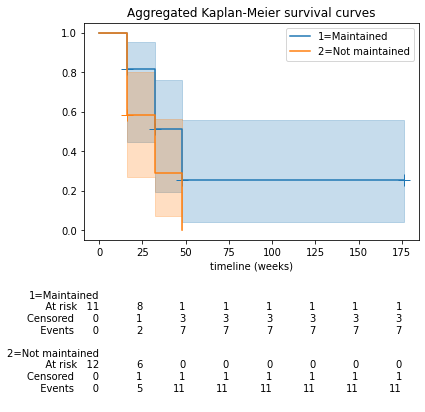

In [11]:
stride = 16
agg_d1, agg_n1 = aggregate(d1, n1, stride)
agg_d2, agg_n2 = aggregate(d2, n2, stride)
agg_d1, agg_n1, agg_d2, agg_n2 = [list(map(int, await mpc.output(_))) for _ in (agg_d1, agg_n1, agg_d2, agg_n2)]
T1_, E1_ = events_from_table(agg_d1, agg_n1)
T2_, E2_ = events_from_table(agg_d2, agg_n2)
T1_, T2_ = [t * stride for t in T1_], [t * stride for t in T2_]
fit_plot(T1_, T2_, E1_, E2_, 'Aggregated Kaplan-Meier survival curves', 'weeks', '1=Maintained', '2=Not maintained')
plt.show()

Picking `stride = 16` achieves a reasonable balance between privacy and utility. To enhance both privacy and utility at the same time, one may look for differentially private randomization techniques, adding a suitable type of noise to the Kaplan-Meier curves. 

### Secure Logrank Tests

The function `logrank_test()` performs a secure logrank test on a secret-shared dataset, similar to function `lifelines.statistics.logrank_test()` used above for a dataset in the clear. The input parameter `secfxp` specifies the secure type to be used for fixed-point arithmetic, and the output is an instance of `lifelines.statistics.StatisticalResult`:

In [12]:
print((await logrank_test(secfxp, d1, d2, n1, n2)).p_value)

0.06533921951089436


Relying solely on p-values is in general not a good idea, and this is especially true when handling otherwise (mostly) hidden data. Together with the aggregated curves, however, the p-value may lead to a useful conclusion for a study. 

The function `logrank_test()` uses one secure fixed-point division per time moment in $1..maxT$. Even though these divisions can all be done in parallel, the total effort is significant when $maxT$ is large. However, "most of the time" there is actually no event happening and no divisions need to be performed for these time moments. E.g., in the survival tables for the aml dataset above, there are only 7 time moments with nonzero `d1` entries on the entire timeline $1..161$, and only 9 time moments with nonzero `d2` entries.

Therefore, it may be advantageous to first extract the nonzero rows of the survival tables, and then limit the computation of the logrank test to those rows. The extraction needs to be done obliviously, not leaking any information about (the location of) the nonzero entries of the survival tables. To prevent this oblivious extraction step from becoming a bottleneck, however, we will actually exploit the fact that the aggregate curves are revealed anyway. We may simply use `agg_d1` and `agg_d2` to bound the number of events per stride, and extract the nonzero rows obliviously and efficiently for each stride. 
This is basically what the function `agg_logrank_test()` does:

In [13]:
print((await agg_logrank_test(secfxp, d1, d2, n1, n2, agg_d1, agg_d2, stride)).p_value)

0.06533925483923529


Even for a small dataset like aml, the speedup is already noticeable. For larger datasets, the speedup gets really substantial, as can be noticed for some of the other datasets included with the [kmsurival.py](kmsurvival.py) demo. 

## Summary
We end with two complete runs of the demo on the aml dataset, showing the Chi2 test statistic and p-value for each logrank test. 

The help message included with the demo shows the command line options:

In [14]:
!python kmsurvival.py -h

Showing help message for kmsurvival.py, if available:

usage: kmsurvival.py [-h] [-i I] [-s S] [-a A] [--collapse] [--print-tables]
                     [--plot-curves]

optional arguments:
  -h, --help          show this help message and exit
  -i I, --dataset I   dataset 0=btrial(default) 1=waltons 2=aml 3=lung 4=dd
                      5=stanford_heart_transplants 6=kidney_transplant
  -s S, --stride S    interval length for aggregated events
  -a A, --accuracy A  number of fractional bits
  --collapse          days->weeks->month->years
  --print-tables      print survival tables
  --plot-curves       plot survival curves


### Complete Run:  5 logrank tests + survival curves
To show the plots of the survival curves the `main()` function of the demo is called directly from a notebook cell:

Using secure fixed-point numbers: SecFxp64:32
Dataset: aml, with 1-party split, time 1 to 161 (stride 16) weeks
Chi2=3.396389, p=0.065339 for all events in the clear
Chi2=3.396389, p=0.065339 for own events in the clear
Chi2=2.685357, p=0.101275 for aggregated events in the clear


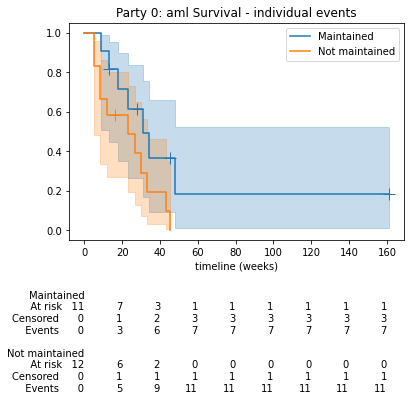

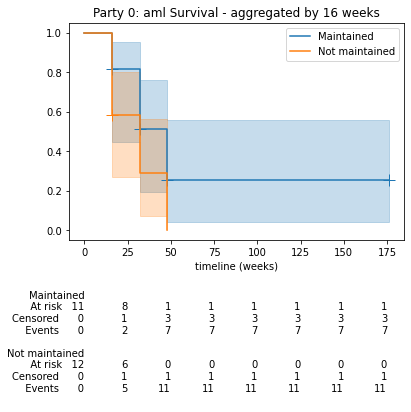

Chi2=3.396391, p=0.065339 for all events secure, exploiting aggregates
Chi2=3.396390, p=0.065339 for all 161 time moments secure


In [15]:
import sys
from kmsurvival import main
sys.argv[1:] = ['-i2', '--plot-curves']
await main()

### Complete Run: 5 logrank tests + survival tables
To run the demo with three parties on localhost, for instance, we add `-M3` as command line option and run [kmsurival.py](kmsurvival.py) outside this notebook using a shell command. The plots are not shown this way, so instead we print the survival tables:

In [16]:
!python kmsurvival.py -M3 -i2 --print-tables --collapse

Using secure fixed-point numbers: SecFxp64:32
Dataset: aml, with 3-party split, time 1 to 41 (stride 4) months
2020-10-31 15:34:40,846 Logrank test on all events in the clear.
Chi2=2.675902, p=0.101878 for all events in the clear
2020-10-31 15:34:40,862 Start MPyC runtime v0.7
2020-10-31 15:34:42,922 All 3 parties connected.
2020-10-31 15:34:42,953 Logrank test on own events in the clear.
Chi2=0.510517, p=0.474915 for own events in the clear
          removed  observed  censored  entrance  at_risk
event_at                                                
0.0             0         0         0         4        4
3.0             1         1         0         0        4
5.0             1         1         0         0        3
8.0             1         1         0         0        2
12.0            1         1         0         0        1
          removed  observed  censored  entrance  at_risk
event_at                                                
0.0             0         0         0    

To try out other runs of the demo for yourself, remember to consult MPyC's help message, using the `-H` option:

In [17]:
!python kmsurvival.py -H

usage: kmsurvival.py [-H] [-h] [-C ini] [-P addr] [-M m] [-I i] [-T t] [-B b]
                     [--ssl] [-L l] [-K k] [--no-log] [--no-async]
                     [--no-barrier] [--no-gmpy2] [--output-windows]
                     [--output-file] [-f F]

optional arguments:
  -H, --HELP            show this help message for MPyC and exit
  -h, --help            show kmsurvival.py help message (if any)

MPyC configuration:
  -C ini, --config ini  use ini file, defining all m parties
  -P addr               use addr=host:port per party (repeat m times)
  -M m                  use m local parties (and run all m, if i is not set)
  -I i, --index i       set index of this local party to i, 0<=i<m
  -T t, --threshold t   threshold t, 0<=t<m/2
  -B b, --base-port b   use port number b+i for party i
  --ssl                 enable SSL connections

MPyC parameters:
  -L l, --bit-length l  default bit length l for secure numbers
  -K k, --sec-param k   security parameter k, leakage probability